In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import sys
import numpy
import pandas as pd
import tensorflow as tf
from keras import layers
import keras


#taking the model
#from VAE_model_extended_moreDKL import *
from VAE_testDK_Reco_Loss import *
import matplotlib.pyplot as plt

import ROOT

2022-07-29 16:35:39.410224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 16:35:39.410317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Welcome to JupyROOT 6.26/04


In [2]:
ROOT.ROOT.EnableImplicitMT()
#RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame

In [3]:
DEBUGGING_MODE = True

def pdf_summary(pdf, debugging_mode=DEBUGGING_MODE):
    print(f"Pandas DataFrame shape is: {pdf.shape}")
    if debugging_mode:
        return pdf.head(1)

### variable from the nutple

In [4]:
#pd_variables = ['deltaetajj', 'deltaphijj', 'etaj1', 'etaj2', 'etal1', 'etal2',
#       'met', 'mjj', 'mll',  'ptj1', 'ptj2', 'ptl1',
#       'ptl2', 'ptll']#,'phij1', 'phij2', 'w']
#kinematicFilter = "ptj1 > 30 && ptj2 >30 && deltaetajj>2 && mjj>200"
kinematicFilter = "ptj1 > 30 && abs(etaj1-etaj2) > 2. && ptj2 >30 && mjj>200"
ntuple_location = "../../ntuples4Momentum/"

In [5]:
dfSM = ROOT.RDataFrame("SSWW_SM",ntuple_location+"ntuple_SSWW_SM.root")
dfSM = dfSM.Filter(kinematicFilter)
dfBSM = ROOT.RDataFrame("SSWW_cW_QU",ntuple_location+"ntuple_SSWW_cW_QU.root")
dfBSM = dfBSM.Filter(kinematicFilter)
np_SM = dfSM.AsNumpy()
wSM = dfSM.AsNumpy(["w"])
npd = pd.DataFrame.from_dict(np_SM)

In [6]:
npd.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)
pdf_summary(npd)

Pandas DataFrame shape is: (895962, 28)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,303.458801,701.662598,66.335213,61.839161,-1.531009,1.705899,-1.010756,0.059856,115.725586,914.647095,...,37.129974,-46.985771,18.432892,-183.381699,20.959143,40.034378,-276.328735,656.85614,-50.817711,3.697025


In [7]:
wpdSM = pd.DataFrame.from_dict(wSM)
pdf_summary(wpdSM)

Pandas DataFrame shape is: (895962, 1)


,w
0,0.005578


In [8]:
# Take all columns og dfBSM because of using RDateFrame.AsNumpy() without any filter
np_BSM = dfBSM.AsNumpy()
wBSM = dfBSM.AsNumpy(["w"])
npd_BSM = pd.DataFrame.from_dict(np_BSM)
pdf_summary(npd_BSM)

Pandas DataFrame shape is: (654461, 33)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,w
0,800.932922,3766.025879,42.786198,499.031891,-2.564578,3.370996,0.230144,0.919019,30.624445,3454.64917,...,-229.1716,118.484314,134.396973,-26.105608,-255.849304,-791.503235,3757.14624,9.676733,362.014282,0.003932


In [9]:
npd_BSM.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)
wpdBSM = pd.DataFrame.from_dict(wBSM)
pdf_summary(wpdBSM)

Pandas DataFrame shape is: (654461, 1)


,w
0,0.003938


In [10]:
nEntries = 3000000
npd = npd.head(nEntries)
npd_BSM = npd_BSM.head(nEntries)
wpdSM = wpdSM.head(nEntries)
wpdBSM = wpdBSM.head(nEntries)

In [11]:
# #to be done for all the pt and mass and met variables
for var in ['met', 'mjj', 'mll', 'ptj1', 'ptj2', 'ptl1',
            'ptl2', 'ptll',"Ej1","Ej2","El1","El2"]:
   npd[var] = np.log10(npd[var])
   npd_BSM[var] = np.log10(npd_BSM[var])
pdf_summary(npd)

Pandas DataFrame shape is: (895962, 28)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,2.4821,2.846128,1.821744,1.791264,-1.531009,1.705899,-1.010756,0.059856,2.063429,2.961254,...,37.129974,-46.985771,18.432892,-183.381699,20.959143,40.034378,-276.328735,656.85614,-50.817711,3.697025


### Combining SM and BSM data

In [12]:
Y_true_SM = np.full(npd.shape[0],0)
Y_true_BSM = np.full(npd_BSM.shape[0],1)
labels_arr = np.concatenate((Y_true_SM,Y_true_BSM))

In [13]:
samples_df = pd.concat([npd,npd_BSM])
samples_df['labels'] = labels_arr
samples_df = samples_df.sample(frac=1)
pdf_summary(samples_df)

Pandas DataFrame shape is: (1550423, 29)


,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,labels
486073,2.398998,2.984704,2.63405,2.740556,-2.338191,0.179762,-1.442716,-0.662163,2.612873,2.83941,...,-20.633226,-47.285328,-932.315796,127.011879,447.840851,-245.985443,171.695801,-385.039673,-319.032471,1


In [14]:
shuffled_labels_df = samples_df['labels']
shuffled_samples_df = samples_df.drop(['labels'], axis='columns')

In [15]:
X_train, X_rem, y_train, y_rem = train_test_split(shuffled_samples_df,
                                                  shuffled_labels_df,
                                                  train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,
                                                    y_rem, 
                                                    test_size=0.5)
SM_train,SM_test,_,_ = train_test_split(npd, npd, test_size=0.2, random_state=1)
BSM_train,BSM_test,_,_ = train_test_split(npd_BSM, npd_BSM, test_size=0.2, random_state=1)
#wx_train, wx_test, wy_train, wy_test = train_test_split(wpdSM, wpdSM, test_size=0.2, random_state=1)

#BSM_train, BSM_test, y_BSM_train, y_BSM_test = train_test_split(npd_BSM, Y_true_BSM, test_size=0.2, random_state=1)
#wBSM_train, wBSM_test, _ , _ = train_test_split(wpdBSM, wpdBSM, test_size=0.2, random_state=1)
#print wx_train,X_train
#wx = wx_train["w"].to_numpy()
#wxtest = wx_test["w"].to_numpy()
#wBSM = wBSM_train["w"].to_numpy()
#wBSMtest = wBSM_test["w"].to_numpy()

### scale data

In [16]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(shuffled_samples_df)
scaled_x_train = scaler.transform(X_train)
scaled_x_valid = scaler.transform(X_valid)
scaled_x_test = scaler.transform(X_test)
BSM_test = scaler.transform(BSM_test)
# scaler.fit(SM_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# BSM_test = scaler.transform(BSM_test)

In [17]:
n_inputs = npd.shape[1]
original_dim = n_inputs

intermediate_dim = 50 #50 by default
input_dim = 10 #was 20 in default
half_input = 7 #was 20 in the newTest
latent_dim = 10 #tried 7 as well  #was 3 for optimal performance
epochs = 20 #80
batch_size=64 #32
nameExtenstion = str(intermediate_dim) + "_" +\
                 str(input_dim) + "_" +\
                 str(half_input) + "_" +\
                 str(latent_dim) + "_" +\
                 str(epochs) + "_" +\
                 str(batch_size)


In [18]:
vae = VariationalAutoEncoder(
                             original_dim, 
                             intermediate_dim, 
                             input_dim, 
                             half_input, 
                             latent_dim,
                             )  
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  
#               loss=tf.keras.losses.MeanSquaredError()
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#               run_eagerly=True, loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
#               loss_weights=[0.1],loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
vae.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss="binary_crossentropy",
                metrics = [tf.keras.metrics.BinaryAccuracy()]
            )
vae_hist = vae.fit(
                    scaled_x_train,
                    y_train,
                    validation_data=(scaled_x_valid, y_valid), 
                    epochs=epochs, 
                    batch_size = batch_size
                ) 

Epoch 1/20
19381/19381 [==============================] - 146s 7ms/step - loss: 0.3575 - binary_accuracy: 0.8570 - val_loss: 0.3034 - val_binary_accuracy: 0.8895
Epoch 2/20
19381/19381 [==============================] - 148s 8ms/step - loss: 0.3057 - binary_accuracy: 0.8878 - val_loss: 0.2989 - val_binary_accuracy: 0.8902
Epoch 3/20
19381/19381 [==============================] - 143s 7ms/step - loss: 0.3005 - binary_accuracy: 0.8891 - val_loss: 0.2942 - val_binary_accuracy: 0.8902
Epoch 4/20
19381/19381 [==============================] - 141s 7ms/step - loss: 0.2979 - binary_accuracy: 0.8896 - val_loss: 0.2949 - val_binary_accuracy: 0.8899
Epoch 5/20
19381/19381 [==============================] - 143s 7ms/step - loss: 0.2954 - binary_accuracy: 0.8903 - val_loss: 0.2934 - val_binary_accuracy: 0.8902
Epoch 6/20
19381/19381 [==============================] - 145s 7ms/step - loss: 0.2939 - binary_accuracy: 0.8905 - val_loss: 0.2918 - val_binary_accuracy: 0.8895
Epoch 7/20
19381/19381 [====

2022-07-29 16:36:05.049207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 16:36:05.049331: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 16:36:05.049403: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2022-07-29 16:36:05.050150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


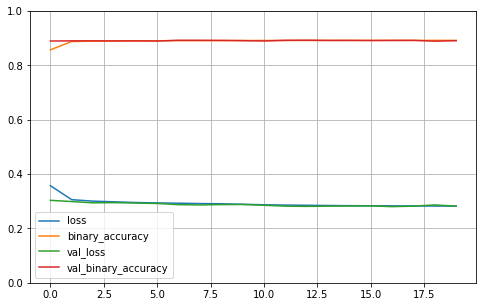

In [25]:
pd.DataFrame(vae_hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
vae.evaluate(X_test, y_test)

4846/4846 [==============================] - 17s 3ms/step - loss: nan - binary_accuracy: 0.3972


[nan, 0.39721882343292236]

In [27]:
encoderDecoder =  EncoderDecoder(original_dim,
                                 intermediate_dim,
                                 input_dim,
                                 half_input,
                                 latent_dim)
reco = encoderDecoder.predict(scaled_x_test)

4846/4846 [==============================] - 13s 3ms/step


In [28]:
keras.models.save_model(encoderDecoder,'encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
keras.models.save_model(vae,'vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
#numpy.savetxt("lossVAE_test_newModelDimenstions_MinMaxScaler_"+nameExtenstion+".csv",hist.history["loss"],delimiter=",")
#vae=tf.keras.models.load_model('vae_test_newModelUsingLatentSpace_'+nameExtenstion)

INFO:tensorflow:Assets written to: encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


In [29]:
output_SM = vae.predict(SM_test)
output_BSM = vae.predict(BSM_test)

4091/4091 [==============================] - 12s 3ms/step


In [30]:
print(vae_hist.history)

{'loss': [0.3574502170085907, 0.3057488203048706, 0.3004668354988098, 0.2978949248790741, 0.2953684329986572, 0.2939186990261078, 0.2928520441055298, 0.2914896607398987, 0.2907521426677704, 0.28897252678871155, 0.28710484504699707, 0.28596067428588867, 0.28517764806747437, 0.28441324830055237, 0.28377193212509155, 0.2834612727165222, 0.28303229808807373, 0.28279390931129456, 0.28234943747520447, 0.2823520302772522], 'binary_accuracy': [0.8570349216461182, 0.8877846002578735, 0.8891229629516602, 0.8895567059516907, 0.8902549147605896, 0.8905467987060547, 0.8908104300498962, 0.8908635973930359, 0.890967607498169, 0.8913223743438721, 0.8915666341781616, 0.8916416168212891, 0.8915150761604309, 0.8917972445487976, 0.891789972782135, 0.891768217086792, 0.8920165300369263, 0.8918690085411072, 0.892001211643219, 0.891876220703125], 'val_loss': [0.3033813536167145, 0.29889076948165894, 0.2942076325416565, 0.2948562800884247, 0.29343515634536743, 0.2917945981025696, 0.287529319524765, 0.28645122

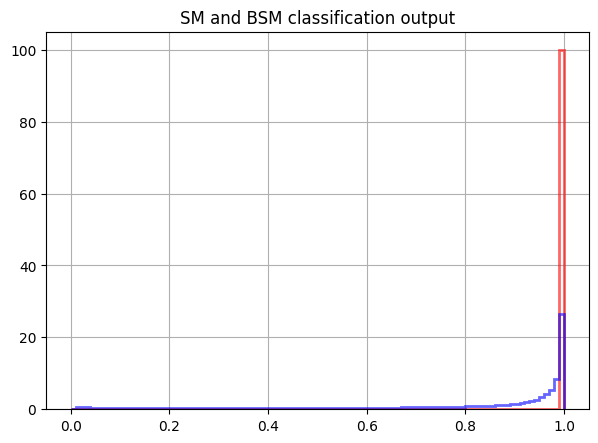

In [31]:
bins=100
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.hist(output_SM,
        bins=bins, 
        density=1,
        range=[0.,1.],
        histtype="step",
        color="red",
        alpha=0.6,
        linewidth=2,
        label="SM Output"
        )                        
ax.hist(output_BSM,
        bins=bins, 
        density=1,
        range=[0.,1.],
        histtype="step",
        color="blue",
        alpha=0.6,
        linewidth=2,
        label="BSM Output"
        )                         
plt.rc('legend',fontsize='small')    
plt.title("SM and BSM classification output") 
plt.show()

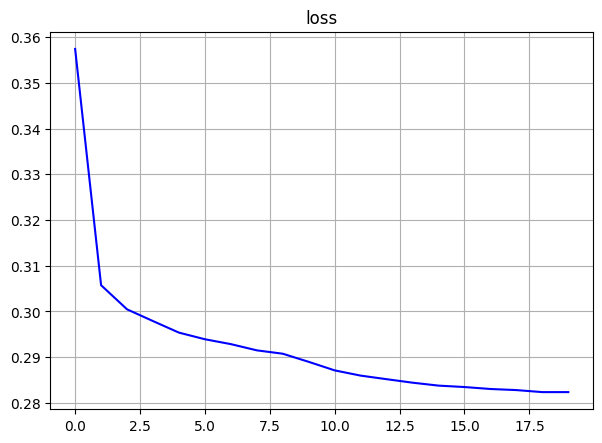

In [32]:
x_bins = range(len(vae_hist.history["loss"]))
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.plot(x_bins,vae_hist.history["loss"],color="blue",label="training losss")                        
plt.rc('legend',fontsize='small') 
plt.title("loss")    
plt.show()

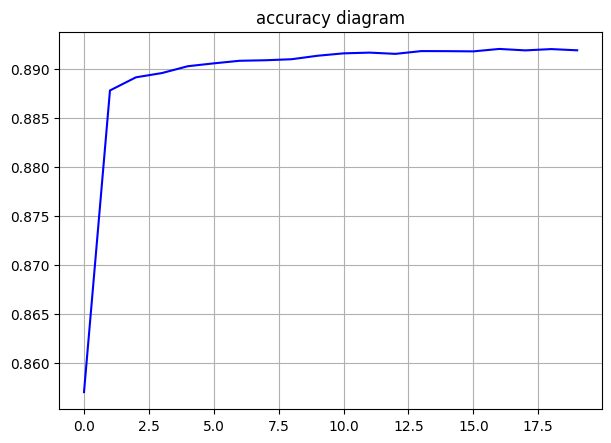

In [33]:
x_bins = range(len(vae_hist.history["binary_accuracy"]))
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.plot(x_bins,vae_hist.history["binary_accuracy"],color="blue",label="binary accuracy")                        
plt.rc('legend',fontsize='small')   
plt.title("accuracy diagram") 
plt.show()